## Start

In [ ]:
!pip install shap
!pip install optuna

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import random
import random
import hashlib

import shap
from sklearn.ensemble import RandomForestRegressor

import optuna
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib

import optuna
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib
import os



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.5 MB/s eta 0:00:00


## Data Preprocessing

In [ ]:
# Load the data
warnings.filterwarnings("ignore")
raw_df = pd.read_csv('World-happiness-report-updated_2024.csv', encoding='latin-1')
raw_df['year'] = raw_df['year'].astype(int)
clean_df = raw_df.copy()

# Preprocessing
# Handle missing data: Iterative Imputer
numerical_cols = clean_df.select_dtypes(include=np.number).columns
imputer = IterativeImputer(max_iter=10, random_state=0)
clean_df[numerical_cols] = imputer.fit_transform(clean_df[numerical_cols])
clean_df['year'] = clean_df['year'].astype(int)
df = clean_df.copy()

# One-hot encode categorical features
categorical_cols = ['Country name']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)


In [ ]:
clean_df[clean_df["Country name"] == "United Kingdom"]

Country name  year  Life Ladder  Log GDP per capita  Social support  \
2207  United Kingdom  2005        6.984              10.661           0.979   
2208  United Kingdom  2007        6.802              10.693           0.970   
2209  United Kingdom  2008        6.986              10.684           0.954   
2210  United Kingdom  2009        6.907              10.630           0.964   
2211  United Kingdom  2010        7.029              10.646           0.955   
2212  United Kingdom  2011        6.869              10.649           0.949   
2213  United Kingdom  2012        6.881              10.656           0.935   
2214  United Kingdom  2013        6.918              10.668           0.937   
2215  United Kingdom  2014        6.758              10.692           0.910   
2216  United Kingdom  2015        6.515              10.707           0.936   
2217  United Kingdom  2016        6.824              10.721           0.954   
2218  United Kingdom  2017        7.103              10.739           0.937   
2219  United Kingdom  2018        7.233              10.750           0.928   
2220  United Kingdom  2019        7.157              10.760           0.943   
2221  United Kingdom  2020        6.798              10.639           0.929   
2222  United Kingdom  2021        6.867              10.713           0.854   
2223  United Kingdom  2022        6.722              10.754           0.863   
2224  United Kingdom  2023        6.658              10.759           0.886   

      Healthy life expectancy at birth  Freedom to make life choices  \
2207                             69.10                         0.922   
2208                             69.22                         0.838   
2209                             69.28                         0.759   
2210                             69.34                         0.816   
2211                             69.40                         0.841   
2212                             69.46                         0.900   
2213                             69.52                         0.889   
2214                             69.58                         0.905   
2215                             69.64                         0.857   
2216                             69.70                         0.833   
2217                             69.80                         0.821   
2218                             69.90                         0.813   
2219                             70.00                         0.838   
2220                             70.10                         0.854   
2221                             70.20                         0.885   
2222                             70.30                         0.815   
2223                             70.40                         0.857   
2224                             70.50                         0.874   

      Generosity  Perceptions of corruption  Positive affect  Negative affect  
2207    0.115906                      0.398            0.779            0.262  
2208    0.331000                      0.498            0.686            0.241  
2209    0.325000                      0.548            0.724            0.218  
2210    0.336000                      0.559            0.739            0.231  
2211    0.397000                      0.587            0.753            0.176  
2212    0.331000                      0.438            0.742            0.174  
2213    0.366000                      0.425            0.739            0.184  
2214    0.341000                      0.568            0.719            0.252  
2215    0.349000                      0.484            0.740            0.251  
2216    0.294000                      0.456            0.740            0.219  
2217    0.244000                      0.458            0.732            0.230  
2218    0.285000                      0.419            0.712            0.210  
2219    0.220000                      0.404            0.736            0.228  
2220    0.264000 

## Check Data Quality

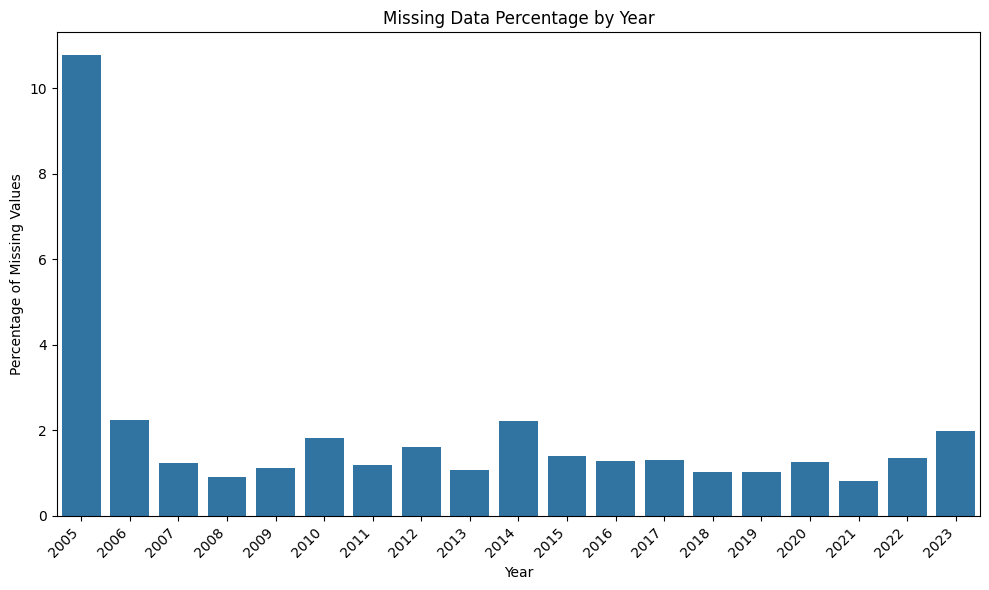

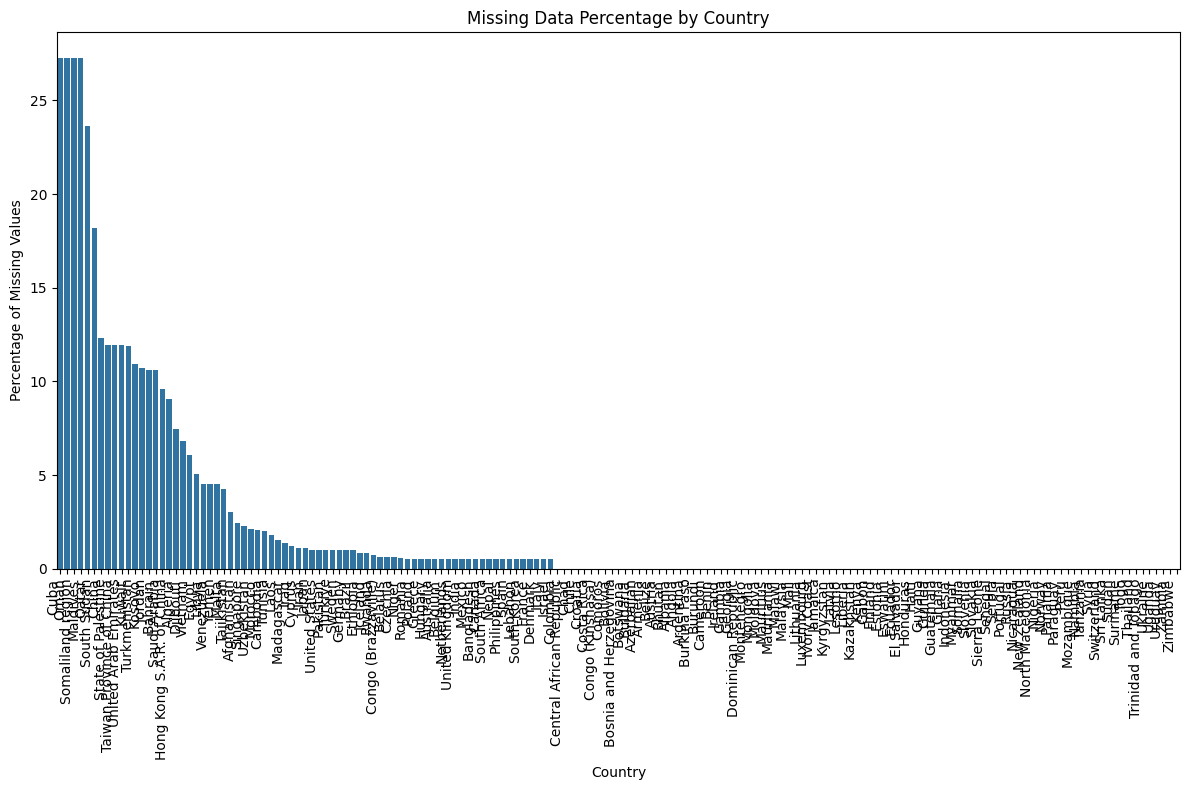

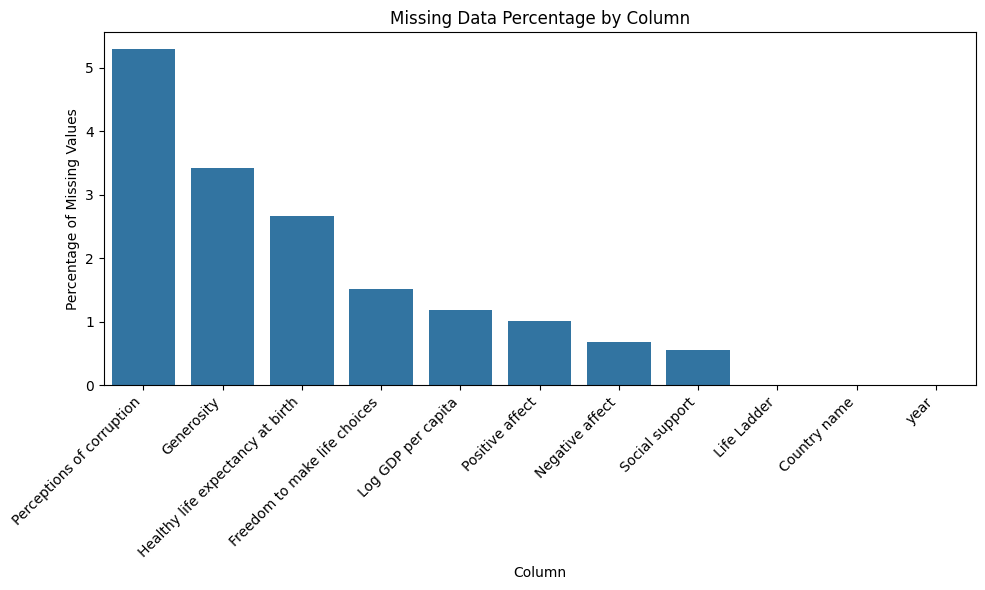

In [ ]:
# Calculate percentage of missing values for each year
missing_percentage_by_year = raw_df.groupby('year').apply(lambda x: x.isnull().mean().mean() * 100).reset_index(name='Missing Percentage')

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='Missing Percentage', data=missing_percentage_by_year)
plt.xlabel('Year')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Data Percentage by Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Calculate percentage of missing values for each country
missing_percentage_by_country = raw_df.groupby('Country name').apply(lambda x: x.isnull().mean().mean() * 100).reset_index(name='Missing Percentage')

# Sort countries by missing percentage in descending order
missing_percentage_by_country = missing_percentage_by_country.sort_values(by=['Missing Percentage'], ascending=False)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Country name', y='Missing Percentage', data=missing_percentage_by_country)
plt.xlabel('Country')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Data Percentage by Country')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


# Calculate percentage of missing values for each column
missing_percentage_by_column = raw_df.isnull().mean() * 100

# Sort columns by missing percentage in descending order
missing_percentage_by_column = missing_percentage_by_column.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage_by_column.index, y=missing_percentage_by_column.values)
plt.xlabel('Column')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Data Percentage by Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## EDA

In [ ]:
df.describe()

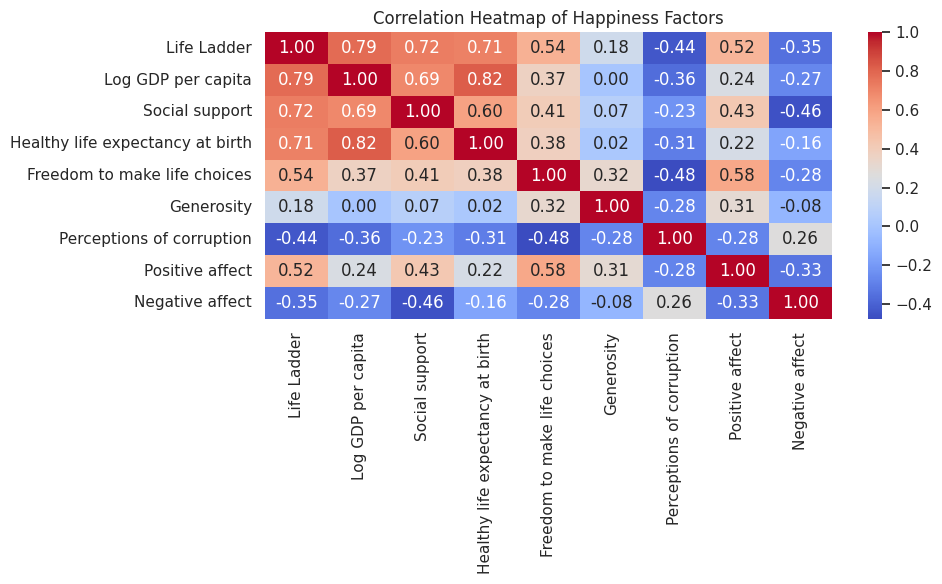

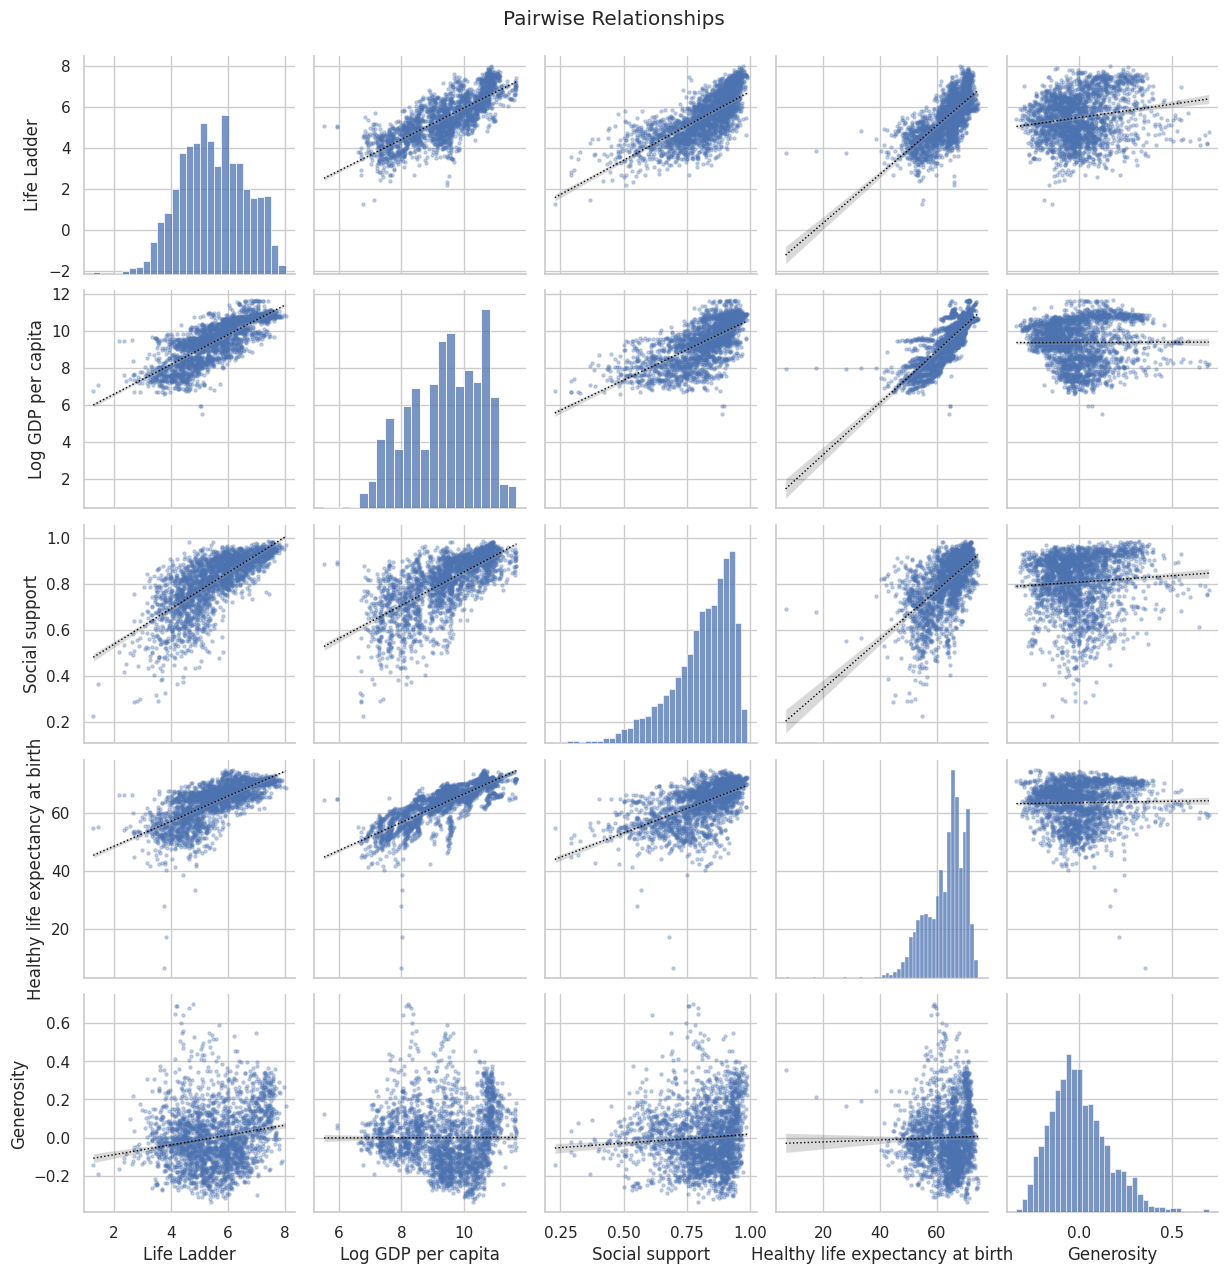

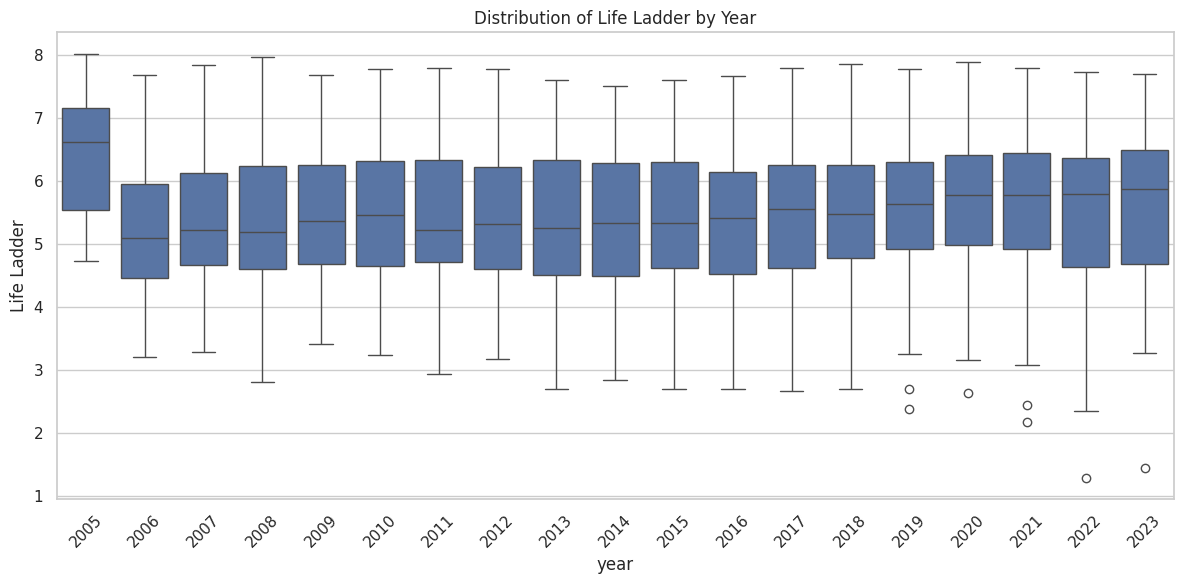

In [ ]:
# Load the dataset
df = clean_df.copy()

# Correlation Heatmap for Explanatory Insight
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
corr = df.drop(columns=["Country name", "year"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Happiness Factors")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Pairplot for Selected Key Variables
selected_vars = ['Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Generosity']
sns.pairplot(df[selected_vars], kind='reg',
             plot_kws={
                 'scatter_kws': {'s': 5, 'alpha': 0.3},
                 'line_kws': {'color': 'black', 'linestyle': 'dotted', 'linewidth': 1}
                 })
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

# Boxplot to show distribution of Life Ladder across years
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='year', y='Life Ladder')
plt.title("Distribution of Life Ladder by Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Map visualization
df = df.sort_values(by=['year'], ascending=True)

fig = px.choropleth(
    df,
    locations="Country name",
    locationmode="country names",
    color="Life Ladder",
    hover_name="Country name",
    animation_frame="year",
    color_continuous_scale='RdYlGn',
    title="World Happiness (Life Ladder) - Dynamic by Year"
)

fig.show()

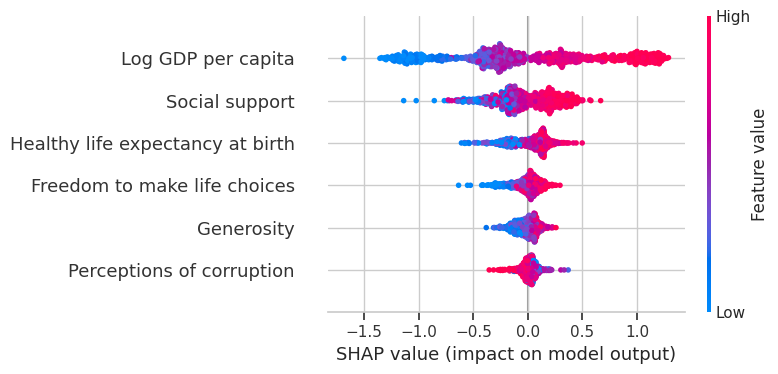

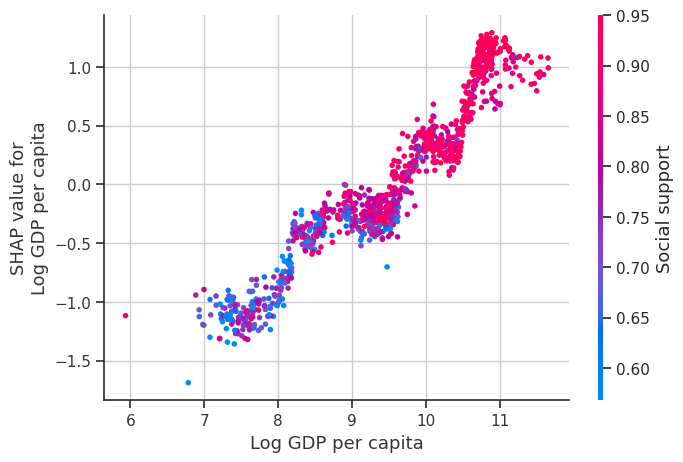

In [ ]:
# SHAP explanation Random Forest
sample_size = 1000
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df.copy()

X_sample = df_sample[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
y_sample = df_sample['Life Ladder']

model_shap = RandomForestRegressor(random_state=42)
model_shap.fit(X_sample, y_sample)

explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)


## Time Series Regression

### Regression by Year - Train/Test split

Evaluating Linear Regression:
  Training: MSE=0.3206, MAE=0.4395, R2=0.7431
  Testing: MSE=0.3178, MAE=0.4279, R2=0.7724


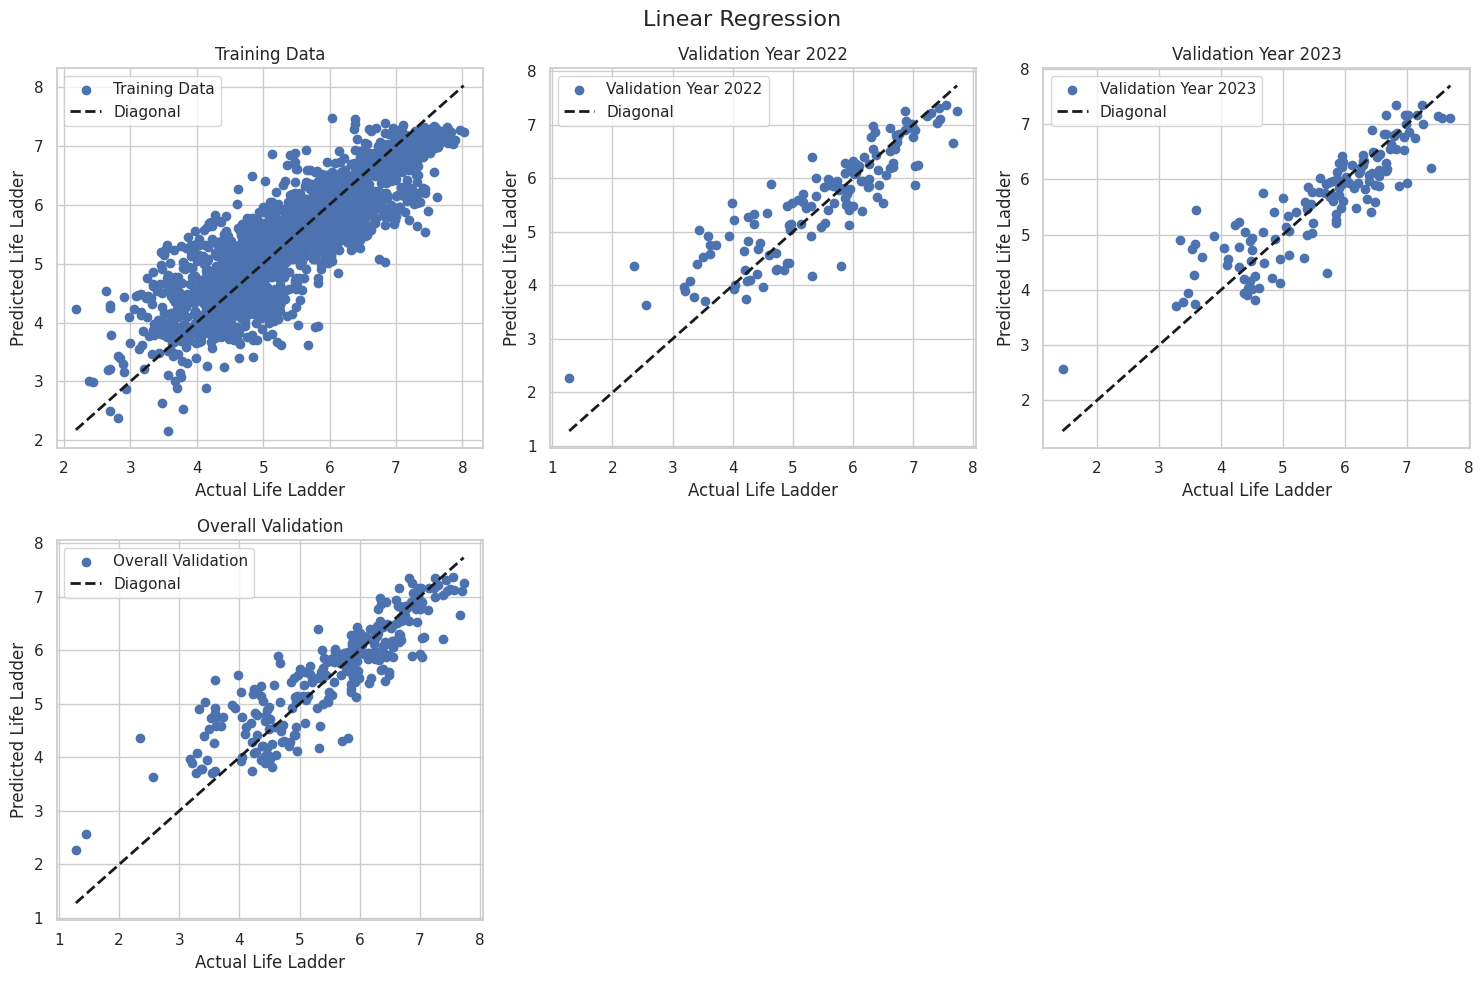

------------------------------
Evaluating Random Forest:
  Training: MSE=0.0279, MAE=0.1240, R2=0.9776
  Testing: MSE=0.2605, MAE=0.3734, R2=0.8135


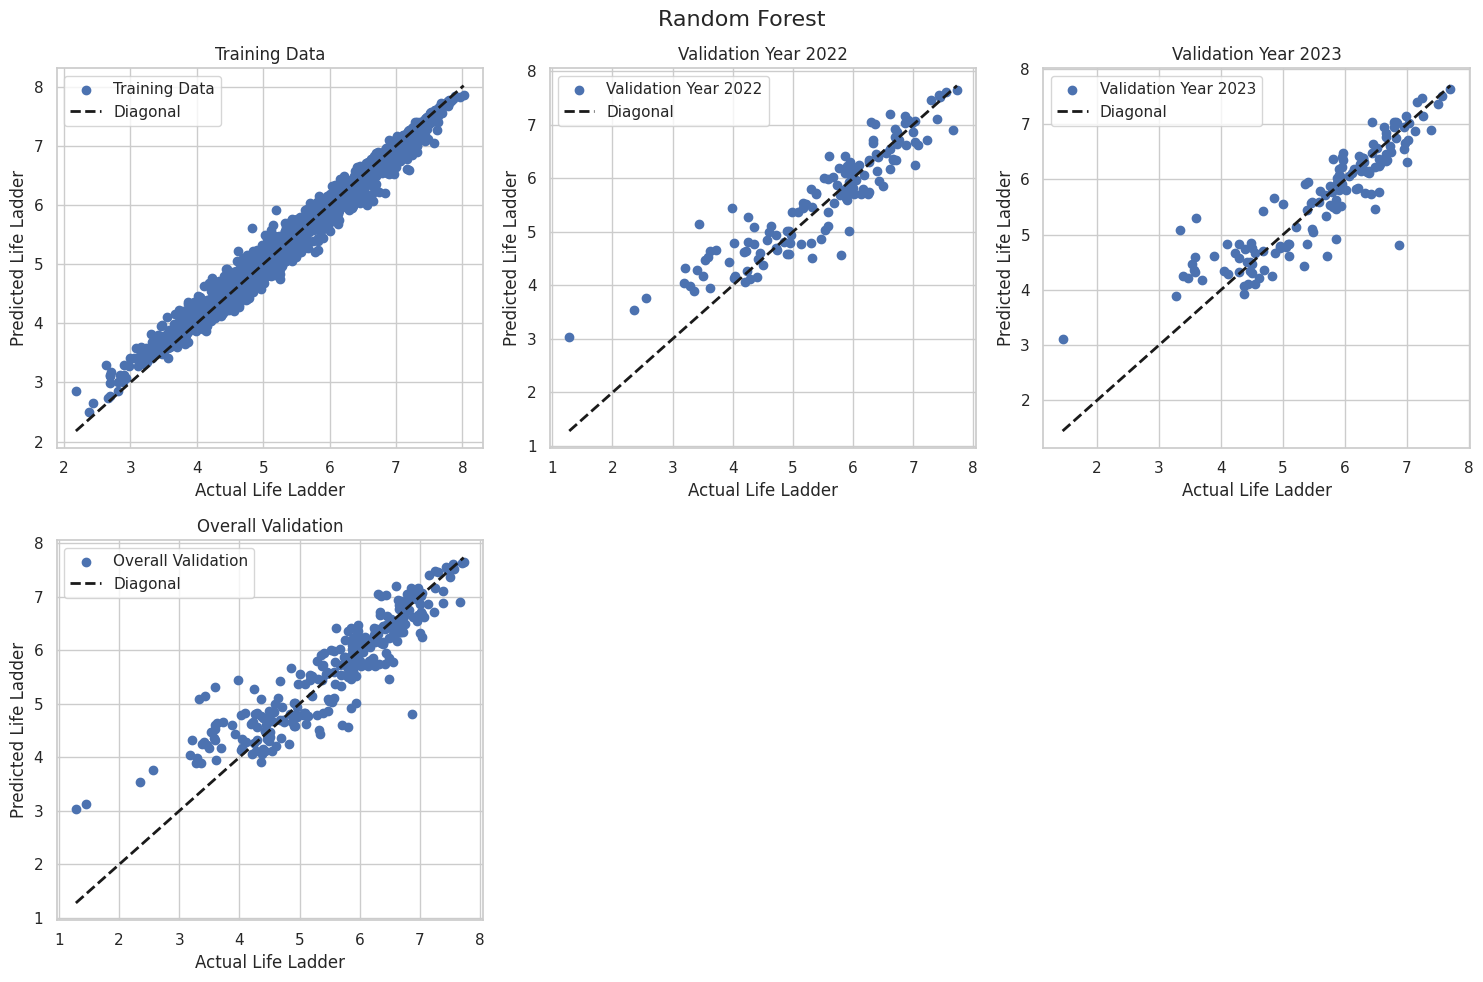

------------------------------
Evaluating Gradient Boosting:
  Training: MSE=0.1780, MAE=0.3266, R2=0.8574
  Testing: MSE=0.3128, MAE=0.4264, R2=0.7760


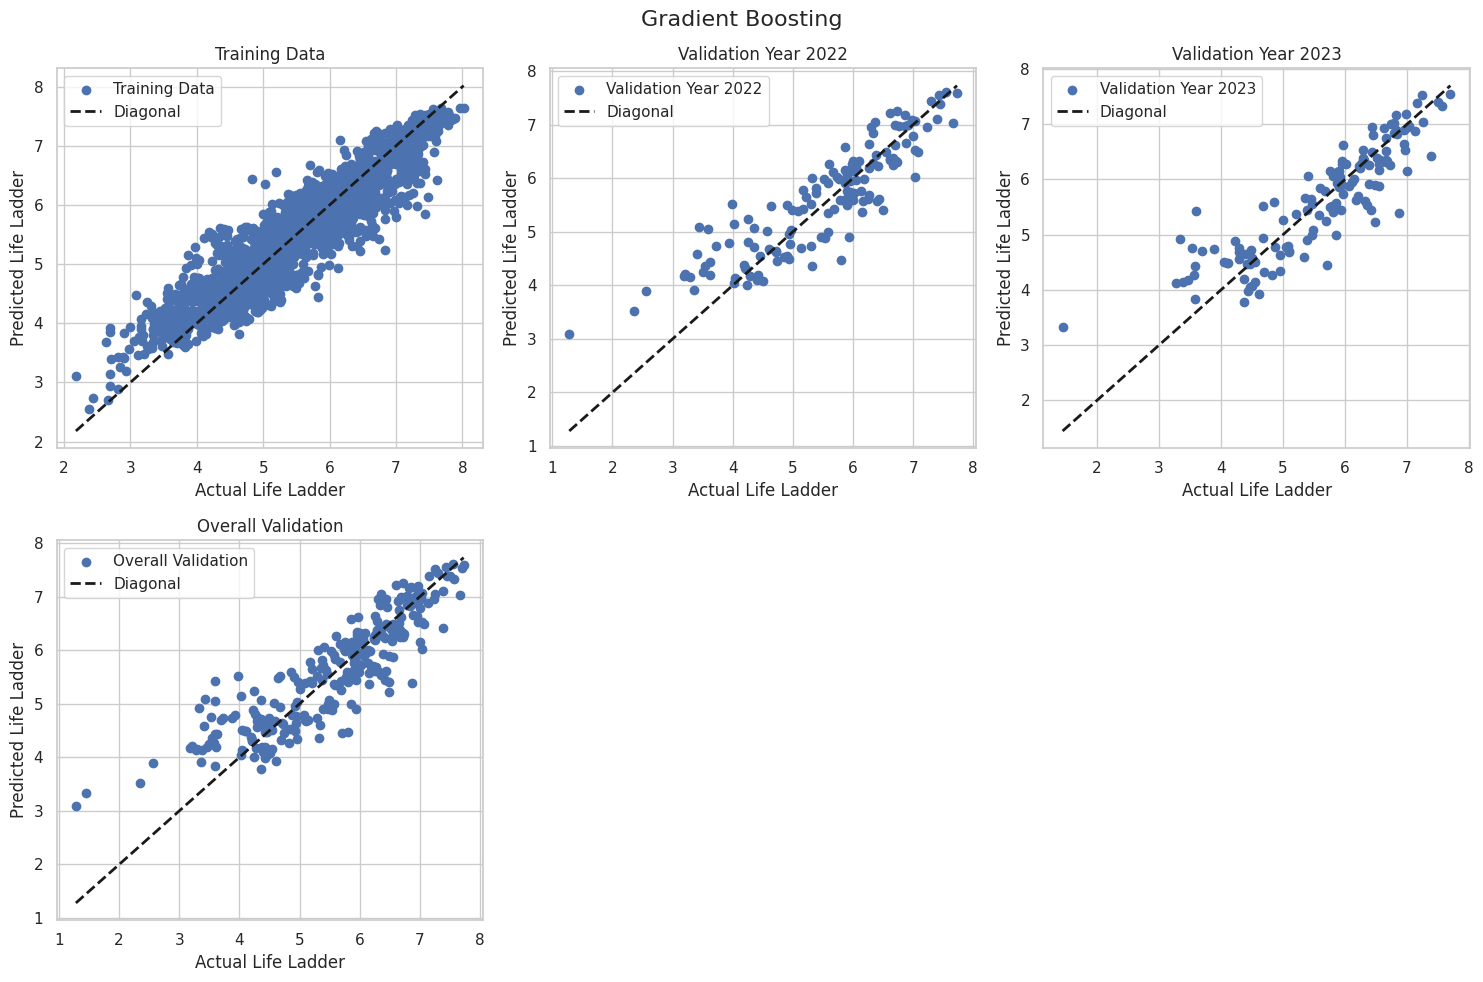

------------------------------
Evaluating XGBoost:
  Training: MSE=0.0076, MAE=0.0624, R2=0.9939
  Testing: MSE=0.3004, MAE=0.3925, R2=0.7849


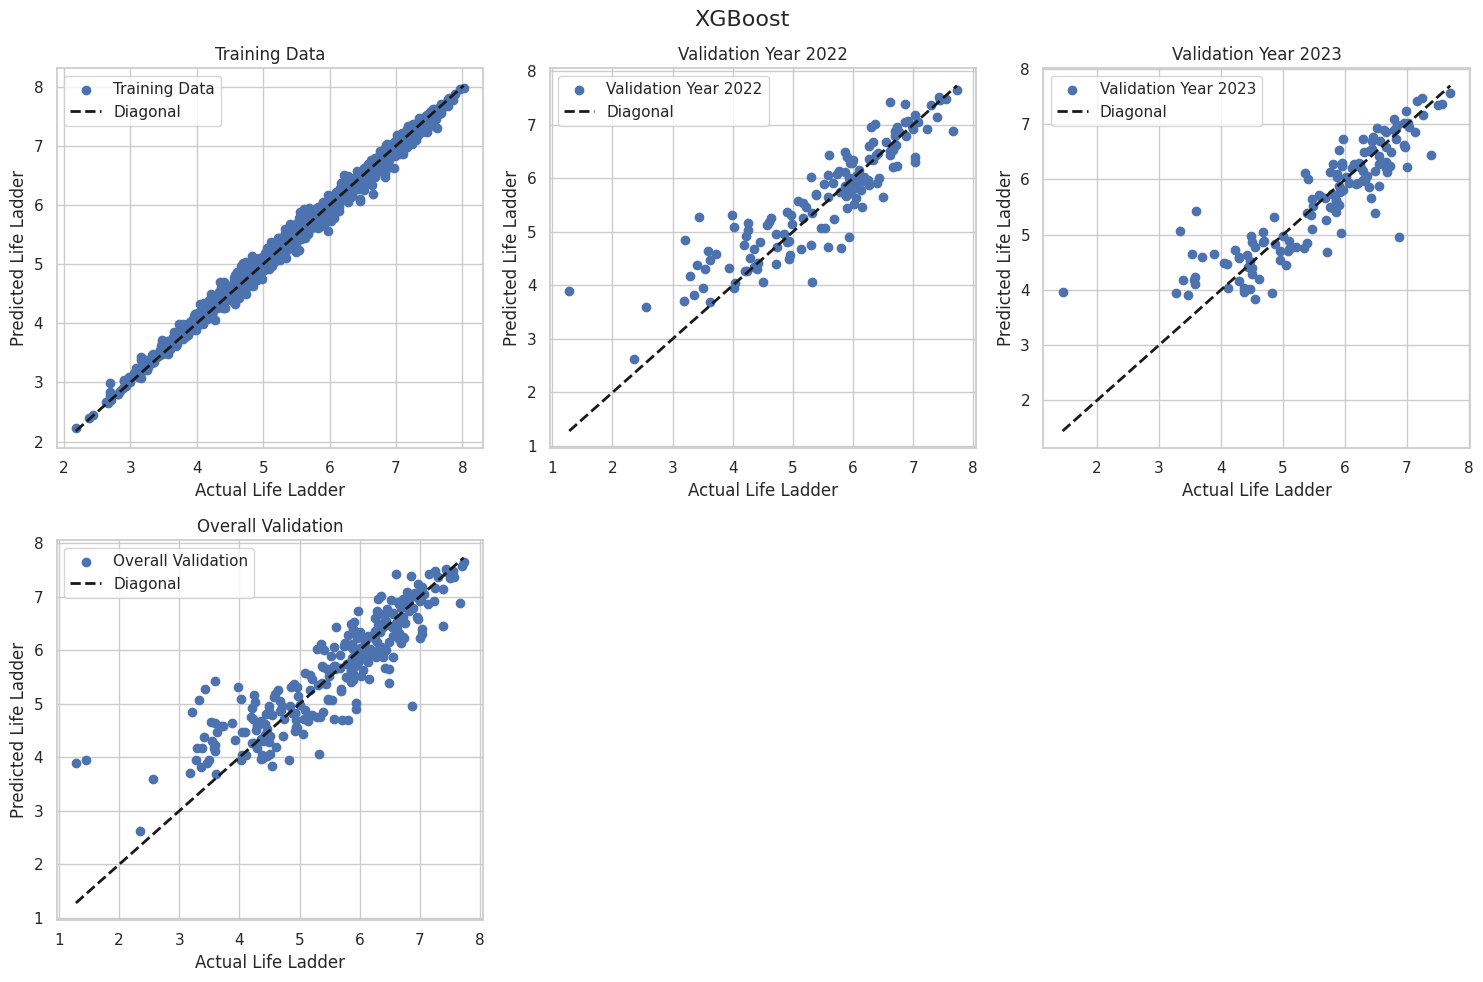

------------------------------


In [ ]:
df = clean_df.copy()
random_number = 42

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=random_number),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0),
    'XGBoost': xgb.XGBRegressor(random_state=random_number)
}

validation_years = [2022, 2023]

for model_name, model in models.items():
    print(f"Evaluating {model_name}:")

    all_predictions_train = []
    all_actual_train = []
    all_predictions_val = []
    all_actual_val = []

    train_data = df[~df['year'].isin(validation_years)]
    validation_data = df[df['year'].isin(validation_years)]

    X_train = train_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                          'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
    y_train = train_data['Life Ladder']
    X_val = validation_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                            'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
    y_val = validation_data['Life Ladder']

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    all_predictions_train.extend(y_pred_train)
    all_actual_train.extend(y_train)

    y_pred_val = model.predict(X_val)
    all_predictions_val.extend(y_pred_val)
    all_actual_val.extend(y_val)

    # Calculate metrics for training data
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    print(f"  Training: MSE={mse_train:.4f}, MAE={mae_train:.4f}, R2={r2_train:.4f}")

    # Calculate metrics for validation data
    mse_val = mean_squared_error(y_val, y_pred_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)
    print(f"  Testing: MSE={mse_val:.4f}, MAE={mae_val:.4f}, R2={r2_val:.4f}")

    # Visualization
    num_plots = len(validation_years) + 2
    num_cols = 3
    num_rows = int(np.ceil(num_plots / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.suptitle(model_name, fontsize=16)

    ax = axes[0, 0] if num_rows > 1 else axes[0]
    ax.scatter(all_actual_train, all_predictions_train, label='Training Data')
    ax.plot([min(all_actual_train), max(all_actual_train)], [min(all_actual_train), max(all_actual_train)], 'k--', lw=2, label='Diagonal')
    ax.set_xlabel('Actual Life Ladder')
    ax.set_ylabel('Predicted Life Ladder')
    ax.set_title('Training Data')
    ax.legend()

    for i, year in enumerate(validation_years):
        row = (i + 1) // num_cols
        col = (i + 1) % num_cols
        ax = axes[row, col]

        year_data_val = validation_data[validation_data['year'] == year]
        y_actual_year = year_data_val['Life Ladder']
        y_pred_year = model.predict(year_data_val[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                                                   'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']])

        ax.scatter(y_actual_year, y_pred_year, label=f'Validation Year {year}')
        ax.plot([y_actual_year.min(), y_actual_year.max()], [y_actual_year.min(), y_actual_year.max()], 'k--', lw=2, label='Diagonal')
        ax.set_xlabel('Actual Life Ladder')
        ax.set_ylabel('Predicted Life Ladder')
        ax.set_title(f'Validation Year {year}')
        ax.legend()

    row = (len(validation_years) + 1) // num_cols
    col = (len(validation_years) + 1) % num_cols
    ax = axes[row, col]
    ax.scatter(all_actual_val, all_predictions_val, label='Overall Validation')
    ax.plot([min(all_actual_val), max(all_actual_val)], [min(all_actual_val), max(all_actual_val)], 'k--', lw=2, label='Diagonal')
    ax.set_xlabel('Actual Life Ladder')
    ax.set_ylabel('Predicted Life Ladder')
    ax.set_title('Overall Validation')
    ax.legend()

    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    print("-" * 30)

### Add Random Seed

In [ ]:
def md5_hash(input_string):
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

input_string = "happiness"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

random.seed(number)
print(f"Initial seed number: {number}")

random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(5)]

print("Seed", random_numbers)

The MD5 hash of 'happiness' is: 695e06655143c0d6c31e47e356558132
The integer representation of the hash is: 140057145183770670784173076211396084018
Initial seed number: 140057145183770670784173076211396084018
Seed [1908474288, 1934061814, 538373376, 1005904197, 839934497]


In [ ]:
# Run on all 5 seeds
df = clean_df.copy()
random_number = 42

validation_years = [2022, 2023]

comparison_results = []
comparison_results_train = []
for seed in random_numbers:
    print(f"Evaluating with random seed: {seed}")
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=seed),
        'Gradient Boosting': GradientBoostingRegressor(random_state=seed),
        'XGBoost': xgb.XGBRegressor(random_state=seed)
    }

    for model_name, model in models.items():

        all_predictions_train = []
        all_actual_train = []
        all_predictions_val = []
        all_actual_val = []

        train_data = df[~df['year'].isin(validation_years)]
        validation_data = df[df['year'].isin(validation_years)]

        X_train = train_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                            'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
        y_train = train_data['Life Ladder']
        X_val = validation_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
        y_val = validation_data['Life Ladder']

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        all_predictions_train.extend(y_pred_train)
        all_actual_train.extend(y_train)

        y_pred_val = model.predict(X_val)
        all_predictions_val.extend(y_pred_val)
        all_actual_val.extend(y_val)

        # Calculate metrics for training data
        mse_train = mean_squared_error(y_train, y_pred_train)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        # print(f"  Training: MSE={mse_train:.4f}, MAE={mae_train:.4f}, R2={r2_train:.4f}")

        # Calculate metrics for validation data
        mse_val = mean_squared_error(y_val, y_pred_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        r2_val = r2_score(y_val, y_pred_val)
        # print(f"  Validation: MSE={mse_val:.4f}, MAE={mae_val:.4f}, R2={r2_val:.4f}")

        comparison_results.append({
            'Model': model_name,
            'Random Seed': seed,
            'MSE': mse_val,
            'MAE': mae_val,
            'R2': r2_val
        })

        comparison_results_train.append({
            'Model': model_name,
            'Random Seed': seed,
            'MSE': mse_train,
            'MAE': mae_train,
            'R2': r2_train
        })

comparison_results_df = pd.DataFrame(comparison_results)
comparison_results_df

comparison_results_train_df = pd.DataFrame(comparison_results_train)
comparison_results_train_df


Evaluating with random seed: 1908474288
Evaluating with random seed: 1934061814
Evaluating with random seed: 538373376
Evaluating with random seed: 1005904197
Evaluating with random seed: 839934497


Model  Random Seed       MSE       MAE        R2
0   Linear Regression   1908474288  0.320606  0.439479  0.743114
1       Random Forest   1908474288  0.027689  0.124101  0.977814
2   Gradient Boosting   1908474288  0.178028  0.326640  0.857355
3             XGBoost   1908474288  0.007581  0.062376  0.993926
4   Linear Regression   1934061814  0.320606  0.439479  0.743114
5       Random Forest   1934061814  0.027256  0.124115  0.978161
6   Gradient Boosting   1934061814  0.178028  0.326640  0.857355
7             XGBoost   1934061814  0.007581  0.062376  0.993926
8   Linear Regression    538373376  0.320606  0.439479  0.743114
9       Random Forest    538373376  0.027427  0.124596  0.978024
10  Gradient Boosting    538373376  0.178028  0.326640  0.857355
11            XGBoost    538373376  0.007581  0.062376  0.993926
12  Linear Regression   1005904197  0.320606  0.439479  0.743114
13      Random Forest   1005904197  0.027777  0.123958  0.977744
14  Gradient Boosting   1005904197  0.178028  0.326640  0.857355
15            XGBoost   1005904197  0.007581  0.062376  0.993926
16  Linear Regression    839934497  0.320606  0.439479  0.743114
17      Random Forest    839934497  0.027552  0.123872  0.977924
18  Gradient Boosting    839934497  0.178028  0.326640  0.857355
19            XGBoost    839934497  0.007581  0.062376  0.993926

### Fine-tuning

In [ ]:
df = clean_df.copy()
validation_years = [2022, 2023]

X = df[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
y = df['Life Ladder']

def objective_linreg(trial, X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_logreg(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    }
    model = LogisticRegression(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_rf(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    model = RandomForestRegressor(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_gb(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
    }
    model = GradientBoostingRegressor(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_xgb(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 0.8),
        'gamma': trial.suggest_loguniform('gamma', 1e-6, 5)
    }
    model = xgb.XGBRegressor(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def optimize_for_seeds(random_numbers, n_trials=100):
    results = {
        'seed': [],
        'linreg_mae': [],
        'rf_mae': [],
        'gb_mae': [],
        'xgb_mae': []
    }
    for seed in random_numbers:
        print(f"[Evaluating with random seed: {seed}]\n")
        sampler = optuna.samplers.TPESampler(seed=seed)  # Use the random seed for the sampler

        train_data = df[~df['year'].isin(validation_years)]
        validation_data = df[df['year'].isin(validation_years)]

        X_train = train_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                              'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
        y_train = train_data['Life Ladder']
        X_val = validation_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
        y_val = validation_data['Life Ladder']

        study_linreg = optuna.create_study(direction='minimize', sampler=sampler)
        study_linreg.optimize(lambda trial: objective_linreg(trial, X_train, y_train, X_val, y_val), n_trials=n_trials)  # Pass data
        linreg_mae = study_linreg.best_value

        # Random Forest optimization
        study_rf = optuna.create_study(direction='minimize', sampler=sampler)
        study_rf.optimize(lambda trial: objective_rf(trial, X_train, y_train, X_val, y_val, seed), n_trials=n_trials)  # Pass data
        rf_mae = study_rf.best_value

        # Gradient Boosting optimization
        study_gb = optuna.create_study(direction='minimize', sampler=sampler)
        study_gb.optimize(lambda trial: objective_gb(trial, X_train, y_train, X_val, y_val, seed), n_trials=n_trials)  # Pass data
        gb_mae = study_gb.best_value

        # XGBoost optimization
        study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
        study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val, seed), n_trials=n_trials)  # Pass data
        xgb_mae = study_xgb.best_value

        results['seed'].append(seed)
        results['linreg_mae'].append(linreg_mae)
        results['rf_mae'].append(rf_mae)
        results['gb_mae'].append(gb_mae)
        results['xgb_mae'].append(xgb_mae)
        print("=====================", results, "=====================")

    results_df = pd.DataFrame(results)
    return results_df

results_df = optimize_for_seeds(random_numbers)
print(results_df)


[I 2025-05-06 02:32:48,713] A new study created in memory with name: no-name-600ed9a0-f638-46f2-88d7-ef97b9069410
[I 2025-05-06 02:32:48,722] Trial 0 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,737] Trial 1 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,746] Trial 2 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,759] Trial 3 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,768] Trial 4 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,781] Trial 5 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48

[Evaluating with random seed: 1908474288]



[I 2025-05-06 02:32:48,932] Trial 14 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,953] Trial 15 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,977] Trial 16 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:48,990] Trial 17 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:49,003] Trial 18 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:49,017] Trial 19 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:32:49,028] Trial 20 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.427

===================== {'seed': [1908474288], 'linreg_mae': [0.4279332720586537], 'rf_mae': [0.3595064024185612], 'gb_mae': [0.3507962244687876], 'xgb_mae': [0.37530641026805633]} =====================
[Evaluating with random seed: 1934061814]



[I 2025-05-06 02:41:34,361] Trial 18 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:41:34,374] Trial 19 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:41:34,382] Trial 20 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:41:34,389] Trial 21 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:41:34,396] Trial 22 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:41:34,403] Trial 23 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:41:34,410] Trial 24 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.427

===================== {'seed': [1908474288, 1934061814], 'linreg_mae': [0.4279332720586537, 0.4279332720586537], 'rf_mae': [0.3595064024185612, 0.3644259580555365], 'gb_mae': [0.3507962244687876, 0.35643791537251346], 'xgb_mae': [0.37530641026805633, 0.37372380255966736]} =====================
[Evaluating with random seed: 538373376]



[I 2025-05-06 02:50:27,377] Trial 15 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:50:27,391] Trial 16 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:50:27,402] Trial 17 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:50:27,409] Trial 18 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:50:27,416] Trial 19 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:50:27,423] Trial 20 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 02:50:27,432] Trial 21 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.427

===================== {'seed': [1908474288, 1934061814, 538373376], 'linreg_mae': [0.4279332720586537, 0.4279332720586537, 0.4279332720586537], 'rf_mae': [0.3595064024185612, 0.3644259580555365, 0.36547117853726846], 'gb_mae': [0.3507962244687876, 0.35643791537251346, 0.3558322686515693], 'xgb_mae': [0.37530641026805633, 0.37372380255966736, 0.372674756434324]} =====================
[Evaluating with random seed: 1005904197]



[I 2025-05-06 03:00:47,764] Trial 13 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:00:47,778] Trial 14 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:00:47,791] Trial 15 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:00:47,802] Trial 16 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:00:47,810] Trial 17 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:00:47,817] Trial 18 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:00:47,841] Trial 19 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.427

===================== {'seed': [1908474288, 1934061814, 538373376, 1005904197], 'linreg_mae': [0.4279332720586537, 0.4279332720586537, 0.4279332720586537, 0.4279332720586537], 'rf_mae': [0.3595064024185612, 0.3644259580555365, 0.36547117853726846, 0.36109723370345365], 'gb_mae': [0.3507962244687876, 0.35643791537251346, 0.3558322686515693, 0.3518440707537432], 'xgb_mae': [0.37530641026805633, 0.37372380255966736, 0.372674756434324, 0.3745983410704908]} =====================
[Evaluating with random seed: 839934497]



[I 2025-05-06 03:10:32,556] Trial 15 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:10:32,569] Trial 16 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:10:32,588] Trial 17 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:10:32,599] Trial 18 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:10:32,618] Trial 19 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:10:32,636] Trial 20 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.4279332720586537.
[I 2025-05-06 03:10:32,646] Trial 21 finished with value: 0.4279332720586537 and parameters: {}. Best is trial 0 with value: 0.427

===================== {'seed': [1908474288, 1934061814, 538373376, 1005904197, 839934497], 'linreg_mae': [0.4279332720586537, 0.4279332720586537, 0.4279332720586537, 0.4279332720586537, 0.4279332720586537], 'rf_mae': [0.3595064024185612, 0.3644259580555365, 0.36547117853726846, 0.36109723370345365, 0.3606590494829454], 'gb_mae': [0.3507962244687876, 0.35643791537251346, 0.3558322686515693, 0.3518440707537432, 0.3582434400128455], 'xgb_mae': [0.37530641026805633, 0.37372380255966736, 0.372674756434324, 0.3745983410704908, 0.37641670900797675]} =====================
         seed  linreg_mae    rf_mae    gb_mae   xgb_mae
0  1908474288    0.427933  0.359506  0.350796  0.375306
1  1934061814    0.427933  0.364426  0.356438  0.373724
2   538373376    0.427933  0.365471  0.355832  0.372675
3  1005904197    0.427933  0.361097  0.351844  0.374598
4   839934497    0.427933  0.360659  0.358243  0.376417


In [ ]:
# Save fine-tuning models
df = clean_df.copy()
validation_years = [2022, 2023]

X = df[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
y = df['Life Ladder']

def objective_linreg(trial, X_train, y_train, X_val, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_rf(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    model = RandomForestRegressor(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_gb(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
    }
    model = GradientBoostingRegressor(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def objective_xgb(trial, X_train, y_train, X_val, y_val, seed):
    random_state = seed
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 0.8),
        'gamma': trial.suggest_loguniform('gamma', 1e-6, 5)
    }
    model = xgb.XGBRegressor(**param, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

def optimize_for_seeds(random_numbers, n_trials=100, save_dir="best_models"):
    results = {
        'seed': [],
        'rf_mae': [],
        'gb_mae': [],
        'xgb_mae': []
    }

    os.makedirs(save_dir, exist_ok=True)

    for seed in random_numbers:
        print(f"[Evaluating with random seed: {seed}]\n")
        sampler = optuna.samplers.TPESampler(seed=seed)

        train_data = df[~df['year'].isin(validation_years)]
        validation_data = df[df['year'].isin(validation_years)]

        X_train = train_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                              'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
        y_train = train_data['Life Ladder']
        X_val = validation_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
        y_val = validation_data['Life Ladder']

        # Random Forest optimization
        study_rf = optuna.create_study(direction='minimize', sampler=sampler)
        study_rf.optimize(lambda trial: objective_rf(trial, X_train, y_train, X_val, y_val, seed), n_trials=n_trials)  # Pass data
        rf_mae = study_rf.best_value
        best_rf_model = RandomForestRegressor(**study_rf.best_params, random_state=seed)
        best_rf_model.fit(X_train, y_train)
        joblib.dump(best_rf_model, os.path.join(save_dir, f'rf_seed_{seed}.pkl'))
        print(f"##### Random Forest model saved to {os.path.join(save_dir, f'rf_seed_{seed}.pkl')} #####")

        # Gradient Boosting optimization
        study_gb = optuna.create_study(direction='minimize', sampler=sampler)
        study_gb.optimize(lambda trial: objective_gb(trial, X_train, y_train, X_val, y_val, seed), n_trials=n_trials)  # Pass data
        gb_mae = study_gb.best_value
        best_gb_model = GradientBoostingRegressor(**study_gb.best_params, random_state=seed)
        best_gb_model.fit(X_train, y_train)
        joblib.dump(best_gb_model, os.path.join(save_dir, f'gb_seed_{seed}.pkl'))
        print(f"##### Gradient Boosting model saved to {os.path.join(save_dir, f'gb_seed_{seed}.pkl')} #####")

        # XGBoost optimization
        study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
        study_xgb.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val, seed), n_trials=n_trials)  # Pass data
        xgb_mae = study_xgb.best_value
        best_xgb_model = xgb.XGBRegressor(**study_xgb.best_params, random_state=seed)
        best_xgb_model.fit(X_train, y_train)
        joblib.dump(best_xgb_model, os.path.join(save_dir, f'xgb_seed_{seed}.pkl'))
        print(f"##### XGBoost model saved to {os.path.join(save_dir, f'xgb_seed_{seed}.pkl')} #####")

        results['seed'].append(seed)
        results['rf_mae'].append(rf_mae)
        results['gb_mae'].append(gb_mae)
        results['xgb_mae'].append(xgb_mae)
        print("=====================", results, "=====================")

    results_df = pd.DataFrame(results)
    return results_df

results_df = optimize_for_seeds(random_numbers)
print(results_df)


[I 2025-05-19 21:22:38,846] A new study created in memory with name: no-name-ac0e4ed1-fc76-4045-adfe-0b5b549d8210


[Evaluating with random seed: 1908474288]



[I 2025-05-19 21:22:48,613] Trial 0 finished with value: 0.40007690608506397 and parameters: {'n_estimators': 968, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.40007690608506397.
[I 2025-05-19 21:22:49,659] Trial 1 finished with value: 0.39582627195028053 and parameters: {'n_estimators': 136, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.39582627195028053.
[I 2025-05-19 21:22:51,145] Trial 2 finished with value: 0.3874132169933359 and parameters: {'n_estimators': 142, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.3874132169933359.
[I 2025-05-19 21:22:56,442] Trial 3 finished with value: 0.4025505080133447 and parameters: {'n_estimators': 541, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 15, '

##### Random Forest model saved to best_models/rf_seed_1908474288.pkl #####


[I 2025-05-19 21:27:31,086] Trial 0 finished with value: 0.9029532319120758 and parameters: {'n_estimators': 111, 'learning_rate': 0.0010036586145931255, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 5, 'subsample': 0.6127982217127411}. Best is trial 0 with value: 0.9029532319120758.
[I 2025-05-19 21:27:31,990] Trial 1 finished with value: 0.5056151441419223 and parameters: {'n_estimators': 104, 'learning_rate': 0.010910919633603987, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.8403115319332821}. Best is trial 1 with value: 0.5056151441419223.
[I 2025-05-19 21:27:32,939] Trial 2 finished with value: 0.672206123218661 and parameters: {'n_estimators': 154, 'learning_rate': 0.0039349591817223325, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 13, 'subsample': 0.8585394785088729}. Best is trial 1 with value: 0.5056151441419223.
[I 2025-05-19 21:27:34,190] Trial 3 finished with value: 0.8779659707519271 and parameters: {'n_estima

##### Gradient Boosting model saved to best_models/gb_seed_1908474288.pkl #####


[I 2025-05-19 21:30:06,557] Trial 1 finished with value: 0.42926568648111907 and parameters: {'learning_rate': 0.17805304877767825, 'n_estimators': 420, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9456242998421089, 'colsample_bytree': 0.36175247319399123, 'gamma': 8.749778008314506e-05}. Best is trial 1 with value: 0.42926568648111907.
[I 2025-05-19 21:30:06,743] Trial 2 finished with value: 0.41603261031006744 and parameters: {'learning_rate': 0.1529230683803373, 'n_estimators': 919, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7673832980075965, 'colsample_bytree': 0.3576233324456035, 'gamma': 0.5318884689532367}. Best is trial 2 with value: 0.41603261031006744.
[I 2025-05-19 21:30:07,081] Trial 3 finished with value: 0.4117026887866233 and parameters: {'learning_rate': 0.059037400176801286, 'n_estimators': 351, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.936145498635467, 'colsample_bytree': 0.34429400744340605, 'gamma': 0.0007459753320471298}. Best is tr

##### XGBoost model saved to best_models/xgb_seed_1908474288.pkl #####
===================== {'seed': [1908474288], 'linreg_mae': [], 'rf_mae': [0.3595064024185612], 'gb_mae': [0.3507962244687876], 'xgb_mae': [0.37530641026805633]} =====================
[Evaluating with random seed: 1934061814]



[I 2025-05-19 21:31:57,321] Trial 0 finished with value: 0.39174201610790843 and parameters: {'n_estimators': 399, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.39174201610790843.
[I 2025-05-19 21:31:58,002] Trial 1 finished with value: 0.45763257085778297 and parameters: {'n_estimators': 246, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.39174201610790843.
[I 2025-05-19 21:31:59,124] Trial 2 finished with value: 0.4512476425873933 and parameters: {'n_estimators': 413, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.39174201610790843.
[I 2025-05-19 21:32:00,079] Trial 3 finished with value: 0.4820120523463351 and parameters: {'n_estimators': 422, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_f

##### Random Forest model saved to best_models/rf_seed_1934061814.pkl #####


[I 2025-05-19 21:35:19,879] Trial 0 finished with value: 0.5285869005878095 and parameters: {'n_estimators': 124, 'learning_rate': 0.009686917534004786, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 7, 'subsample': 0.6766674621431541}. Best is trial 0 with value: 0.5285869005878095.
[I 2025-05-19 21:35:21,162] Trial 1 finished with value: 0.42400507676175647 and parameters: {'n_estimators': 183, 'learning_rate': 0.011284330834083105, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 12, 'subsample': 0.8039742789547745}. Best is trial 1 with value: 0.42400507676175647.
[I 2025-05-19 21:35:22,918] Trial 2 finished with value: 0.45014386699193387 and parameters: {'n_estimators': 186, 'learning_rate': 0.008031011097287493, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 15, 'subsample': 0.8931926497841249}. Best is trial 1 with value: 0.42400507676175647.
[I 2025-05-19 21:35:24,223] Trial 3 finished with value: 0.42040686478512496 and parameters: {'n_e

##### Gradient Boosting model saved to best_models/gb_seed_1934061814.pkl #####


[I 2025-05-19 21:38:06,540] Trial 0 finished with value: 0.4199641066695289 and parameters: {'learning_rate': 0.1454667195891472, 'n_estimators': 702, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.553289200937388, 'colsample_bytree': 0.460910032353189, 'gamma': 0.00032671842049991883}. Best is trial 0 with value: 0.4199641066695289.
[I 2025-05-19 21:38:06,804] Trial 1 finished with value: 0.41293135325342634 and parameters: {'learning_rate': 0.0453509859555878, 'n_estimators': 320, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.5096931388500694, 'colsample_bytree': 0.3682283186583568, 'gamma': 0.010377767601928831}. Best is trial 1 with value: 0.41293135325342634.
[I 2025-05-19 21:38:07,163] Trial 2 finished with value: 0.4126588039809852 and parameters: {'learning_rate': 0.036987716706965865, 'n_estimators': 877, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8970635140330705, 'colsample_bytree': 0.411066444801022, 'gamma': 0.0024754708737165783}. Best is trial 2

##### XGBoost model saved to best_models/xgb_seed_1934061814.pkl #####
===================== {'seed': [1908474288, 1934061814], 'linreg_mae': [], 'rf_mae': [0.3595064024185612, 0.3644259580555365], 'gb_mae': [0.3507962244687876, 0.35643791537251346], 'xgb_mae': [0.37530641026805633, 0.37372380255966736]} =====================
[Evaluating with random seed: 538373376]



[I 2025-05-19 21:41:03,828] Trial 0 finished with value: 0.41483122153551716 and parameters: {'n_estimators': 671, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.41483122153551716.
[I 2025-05-19 21:41:08,211] Trial 1 finished with value: 0.4094680713062442 and parameters: {'n_estimators': 984, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.4094680713062442.
[I 2025-05-19 21:41:10,745] Trial 2 finished with value: 0.39520380619738166 and parameters: {'n_estimators': 529, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.39520380619738166.
[I 2025-05-19 21:41:13,380] Trial 3 finished with value: 0.4001191833878169 and parameters: {'n_estimators': 585, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 14, 'm

##### Random Forest model saved to best_models/rf_seed_538373376.pkl #####


[I 2025-05-19 21:45:41,338] Trial 0 finished with value: 0.7367959779770846 and parameters: {'n_estimators': 183, 'learning_rate': 0.002178668388056148, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 10, 'subsample': 0.7851675305861617}. Best is trial 0 with value: 0.7367959779770846.
[I 2025-05-19 21:45:41,785] Trial 1 finished with value: 0.43401273834771825 and parameters: {'n_estimators': 54, 'learning_rate': 0.031938413102897405, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 20, 'subsample': 0.865752851183244}. Best is trial 1 with value: 0.43401273834771825.
[I 2025-05-19 21:45:42,854] Trial 2 finished with value: 0.7972063816918741 and parameters: {'n_estimators': 112, 'learning_rate': 0.002565488426966229, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 16, 'subsample': 0.8258068868072591}. Best is trial 1 with value: 0.43401273834771825.
[I 2025-05-19 21:45:43,296] Trial 3 finished with value: 0.4182573592078859 and parameters: {'n_est

##### Gradient Boosting model saved to best_models/gb_seed_538373376.pkl #####


[I 2025-05-19 21:48:18,575] Trial 0 finished with value: 0.40643697970548126 and parameters: {'learning_rate': 0.011693427166894652, 'n_estimators': 879, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.5900514113167905, 'colsample_bytree': 0.5625877409249072, 'gamma': 1.2743152846594403e-06}. Best is trial 0 with value: 0.40643697970548126.
[I 2025-05-19 21:48:19,519] Trial 1 finished with value: 0.4149407686947061 and parameters: {'learning_rate': 0.015120437867846392, 'n_estimators': 489, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.5106183430544355, 'colsample_bytree': 0.4385500881448509, 'gamma': 0.00021672550872625033}. Best is trial 0 with value: 0.40643697970548126.
[I 2025-05-19 21:48:19,738] Trial 2 finished with value: 0.43699325586909016 and parameters: {'learning_rate': 0.01153607662277525, 'n_estimators': 564, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9888952443408038, 'colsample_bytree': 0.7812657242252345, 'gamma': 4.4635928211642675}. Best is 

##### XGBoost model saved to best_models/xgb_seed_538373376.pkl #####
===================== {'seed': [1908474288, 1934061814, 538373376], 'linreg_mae': [], 'rf_mae': [0.3595064024185612, 0.3644259580555365, 0.36547117853726846], 'gb_mae': [0.3507962244687876, 0.35643791537251346, 0.3558322686515693], 'xgb_mae': [0.37530641026805633, 0.37372380255966736, 0.372674756434324]} =====================
[Evaluating with random seed: 1005904197]



[I 2025-05-19 21:51:32,241] Trial 0 finished with value: 0.4260231845202616 and parameters: {'n_estimators': 382, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.4260231845202616.
[I 2025-05-19 21:51:35,469] Trial 1 finished with value: 0.40116325092643473 and parameters: {'n_estimators': 740, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.40116325092643473.
[I 2025-05-19 21:51:36,439] Trial 2 finished with value: 0.42105876095778266 and parameters: {'n_estimators': 287, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.40116325092643473.
[I 2025-05-19 21:51:38,180] Trial 3 finished with value: 0.4221583548999022 and parameters: {'n_estimators': 422, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max

##### Random Forest model saved to best_models/rf_seed_1005904197.pkl #####


[I 2025-05-19 21:56:54,343] Trial 0 finished with value: 0.7732918286835446 and parameters: {'n_estimators': 156, 'learning_rate': 0.0021117867833006627, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 14, 'subsample': 0.9594899168312704}. Best is trial 0 with value: 0.7732918286835446.
[I 2025-05-19 21:56:55,189] Trial 1 finished with value: 0.6058598457967533 and parameters: {'n_estimators': 119, 'learning_rate': 0.006697542397490271, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'subsample': 0.6861238226645838}. Best is trial 1 with value: 0.6058598457967533.
[I 2025-05-19 21:56:57,910] Trial 2 finished with value: 0.8342368587122181 and parameters: {'n_estimators': 199, 'learning_rate': 0.0010819349304281953, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 8, 'subsample': 0.9858471764799432}. Best is trial 1 with value: 0.6058598457967533.
[I 2025-05-19 21:56:58,893] Trial 3 finished with value: 0.5256900485003929 and parameters: {'n_estima

##### Gradient Boosting model saved to best_models/gb_seed_1005904197.pkl #####


[I 2025-05-19 21:59:57,435] Trial 0 finished with value: 0.3978439413592112 and parameters: {'learning_rate': 0.09561068052338982, 'n_estimators': 489, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9527986037774167, 'colsample_bytree': 0.7219389084991437, 'gamma': 0.004334552971946913}. Best is trial 0 with value: 0.3978439413592112.
[I 2025-05-19 21:59:58,009] Trial 1 finished with value: 0.4122493159410765 and parameters: {'learning_rate': 0.045654128732507016, 'n_estimators': 960, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5504044703270803, 'colsample_bytree': 0.42483350791920177, 'gamma': 0.06623308900330348}. Best is trial 0 with value: 0.3978439413592112.
[I 2025-05-19 21:59:58,609] Trial 2 finished with value: 0.3993279474381921 and parameters: {'learning_rate': 0.022424021935343836, 'n_estimators': 580, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7158012641456397, 'colsample_bytree': 0.5368148308782754, 'gamma': 0.005591817782591288}. Best is trial

##### XGBoost model saved to best_models/xgb_seed_1005904197.pkl #####
===================== {'seed': [1908474288, 1934061814, 538373376, 1005904197], 'linreg_mae': [], 'rf_mae': [0.3595064024185612, 0.3644259580555365, 0.36547117853726846, 0.36109723370345365], 'gb_mae': [0.3507962244687876, 0.35643791537251346, 0.3558322686515693, 0.3518440707537432], 'xgb_mae': [0.37530641026805633, 0.37372380255966736, 0.372674756434324, 0.3745983410704908]} =====================
[Evaluating with random seed: 839934497]



[I 2025-05-19 22:01:26,804] Trial 0 finished with value: 0.43954649676009266 and parameters: {'n_estimators': 329, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.43954649676009266.
[I 2025-05-19 22:01:28,195] Trial 1 finished with value: 0.4204266096058129 and parameters: {'n_estimators': 404, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.4204266096058129.
[I 2025-05-19 22:01:29,809] Trial 2 finished with value: 0.37762621242519373 and parameters: {'n_estimators': 309, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.37762621242519373.
[I 2025-05-19 22:01:33,098] Trial 3 finished with value: 0.43978766846500184 and parameters: {'n_estimators': 881, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max

##### Random Forest model saved to best_models/rf_seed_839934497.pkl #####


[I 2025-05-19 22:05:49,377] Trial 0 finished with value: 0.3874950020768943 and parameters: {'n_estimators': 198, 'learning_rate': 0.016463066398604204, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 18, 'subsample': 0.9033312951498672}. Best is trial 0 with value: 0.3874950020768943.
[I 2025-05-19 22:05:50,085] Trial 1 finished with value: 0.6972621262049478 and parameters: {'n_estimators': 125, 'learning_rate': 0.004263034006050905, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 7, 'subsample': 0.7466184777428805}. Best is trial 0 with value: 0.3874950020768943.
[I 2025-05-19 22:05:51,049] Trial 2 finished with value: 0.38627713419308063 and parameters: {'n_estimators': 118, 'learning_rate': 0.037906925306209135, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 16, 'subsample': 0.6701771318104204}. Best is trial 2 with value: 0.38627713419308063.
[I 2025-05-19 22:05:53,131] Trial 3 finished with value: 0.41597386343261616 and parameters: {'n_esti

##### Gradient Boosting model saved to best_models/gb_seed_839934497.pkl #####


[I 2025-05-19 22:08:13,361] Trial 1 finished with value: 0.41575302003956527 and parameters: {'learning_rate': 0.017777479831353853, 'n_estimators': 138, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7716867190336079, 'colsample_bytree': 0.6030943157473987, 'gamma': 0.08675312374667889}. Best is trial 1 with value: 0.41575302003956527.
[I 2025-05-19 22:08:13,667] Trial 2 finished with value: 0.4187219439650611 and parameters: {'learning_rate': 0.010186008221546194, 'n_estimators': 808, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8362006675175817, 'colsample_bytree': 0.3480872879260393, 'gamma': 0.21079763360145293}. Best is trial 1 with value: 0.41575302003956527.
[I 2025-05-19 22:08:13,948] Trial 3 finished with value: 0.4101619771847622 and parameters: {'learning_rate': 0.059335098186393306, 'n_estimators': 482, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7807866998898664, 'colsample_bytree': 0.42032218801668847, 'gamma': 2.535640291722928e-06}. Best is t

##### XGBoost model saved to best_models/xgb_seed_839934497.pkl #####
===================== {'seed': [1908474288, 1934061814, 538373376, 1005904197, 839934497], 'linreg_mae': [], 'rf_mae': [0.3595064024185612, 0.3644259580555365, 0.36547117853726846, 0.36109723370345365, 0.3606590494829454], 'gb_mae': [0.3507962244687876, 0.35643791537251346, 0.3558322686515693, 0.3518440707537432, 0.3582434400128455], 'xgb_mae': [0.37530641026805633, 0.37372380255966736, 0.372674756434324, 0.3745983410704908, 0.37641670900797675]} =====================


ValueError: All arrays must be of the same length

### Predict with best model

In [ ]:
df = clean_df.copy()
validation_years = [2022, 2023]

X = df[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
y = df['Life Ladder']

train_data = df[~df['year'].isin(validation_years)]
validation_data = df[df['year'].isin(validation_years)]

X_train = train_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                      'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
y_train = train_data['Life Ladder']
X_val = validation_data[['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth',
                        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]
y_val = validation_data['Life Ladder']

load_dir = "best_models"

evaluation_results = []

for seed in random_numbers:
    print(f"Evaluating models for random seed: {seed}")

    models_to_load = {
        'Random Forest': os.path.join(load_dir, f'rf_seed_{seed}.pkl'),
        'Gradient Boosting': os.path.join(load_dir, f'gb_seed_{seed}.pkl'),
        'XGBoost': os.path.join(load_dir, f'xgb_seed_{seed}.pkl')
    }

    linreg_model = LinearRegression()
    linreg_model.fit(X_train, y_train)

    y_pred_linreg = linreg_model.predict(X_val)
    evaluation_results.append({
        'Model': 'Linear Regression',
        'Random Seed': seed,
        'MSE': mean_squared_error(y_val, y_pred_linreg),
        'MAE': mean_absolute_error(y_val, y_pred_linreg),
        'R2': r2_score(y_val, y_pred_linreg)
    })


    for model_name, model_path in models_to_load.items():
        if os.path.exists(model_path):
            print(f"Loading {model_name} model from {model_path}")
            loaded_model = joblib.load(model_path)

            y_pred = loaded_model.predict(X_val)

            mse = mean_squared_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            evaluation_results.append({
                'Model': model_name,
                'Random Seed': seed,
                'MSE': mse,
                'MAE': mae,
                'R2': r2
            })
            print(f"  {model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
        else:
            print(f"Model file not found for {model_name} with seed {seed} at {model_path}")

evaluation_df = pd.DataFrame(evaluation_results)

print("\nEvaluation Metrics for All Models and Seeds:")
evaluation_df



Evaluating models for random seed: 1908474288
Loading Random Forest model from best_models/rf_seed_1908474288.pkl
  Random Forest - MSE: 0.2491, MAE: 0.3595, R2: 0.8216
Loading Gradient Boosting model from best_models/gb_seed_1908474288.pkl
  Gradient Boosting - MSE: 0.2421, MAE: 0.3508, R2: 0.8266
Loading XGBoost model from best_models/xgb_seed_1908474288.pkl
  XGBoost - MSE: 0.2697, MAE: 0.3753, R2: 0.8069
Evaluating models for random seed: 1934061814
Loading Random Forest model from best_models/rf_seed_1934061814.pkl
  Random Forest - MSE: 0.2521, MAE: 0.3644, R2: 0.8194
Loading Gradient Boosting model from best_models/gb_seed_1934061814.pkl
  Gradient Boosting - MSE: 0.2475, MAE: 0.3564, R2: 0.8228
Loading XGBoost model from best_models/xgb_seed_1934061814.pkl
  XGBoost - MSE: 0.2677, MAE: 0.3737, R2: 0.8083
Evaluating models for random seed: 538373376
Loading Random Forest model from best_models/rf_seed_538373376.pkl
  Random Forest - MSE: 0.2532, MAE: 0.3655, R2: 0.8187
Loading G

Model  Random Seed       MSE       MAE        R2
0   Linear Regression   1908474288  0.317790  0.427933  0.772411
1       Random Forest   1908474288  0.249119  0.359506  0.821590
2   Gradient Boosting   1908474288  0.242066  0.350796  0.826642
3             XGBoost   1908474288  0.269697  0.375306  0.806854
4   Linear Regression   1934061814  0.317790  0.427933  0.772411
5       Random Forest   1934061814  0.252109  0.364426  0.819450
6   Gradient Boosting   1934061814  0.247459  0.356438  0.822780
7             XGBoost   1934061814  0.267741  0.373724  0.808255
8   Linear Regression    538373376  0.317790  0.427933  0.772411
9       Random Forest    538373376  0.253171  0.365471  0.818689
10  Gradient Boosting    538373376  0.243098  0.355832  0.825903
11            XGBoost    538373376  0.265082  0.372675  0.810159
12  Linear Regression   1005904197  0.317790  0.427933  0.772411
13      Random Forest   1005904197  0.250130  0.361097  0.820867
14  Gradient Boosting   1005904197  0.238575  0.351844  0.829142
15            XGBoost   1005904197  0.278148  0.374598  0.800802
16  Linear Regression    839934497  0.317790  0.427933  0.772411
17      Random Forest    839934497  0.252242  0.360659  0.819354
18  Gradient Boosting    839934497  0.240213  0.358243  0.827969
19            XGBoost    839934497  0.267356  0.376417  0.808530

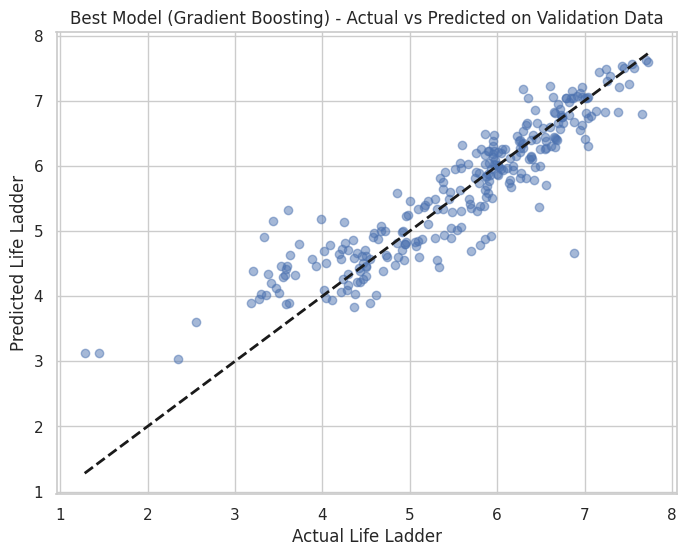

SHAP Summary Plot:


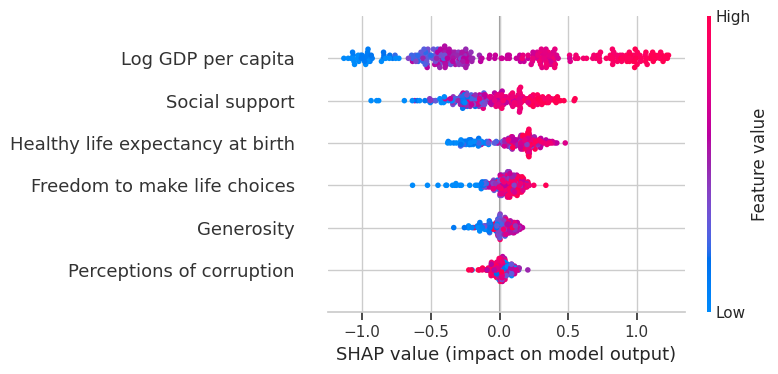


SHAP Dependence Plot for 'Log GDP per capita':


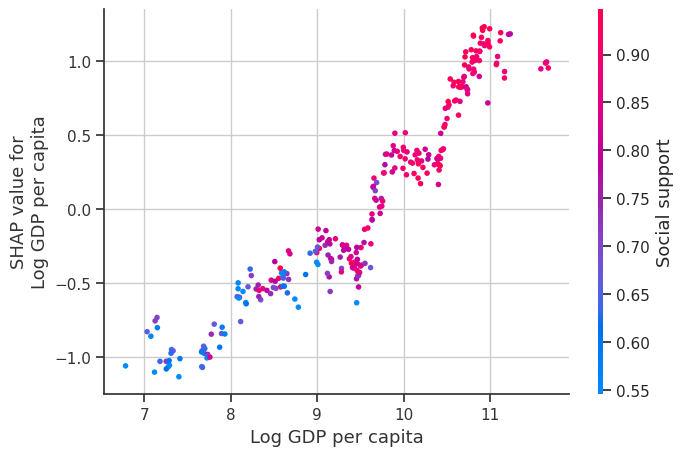


SHAP Dependence Plot for 'Social support':


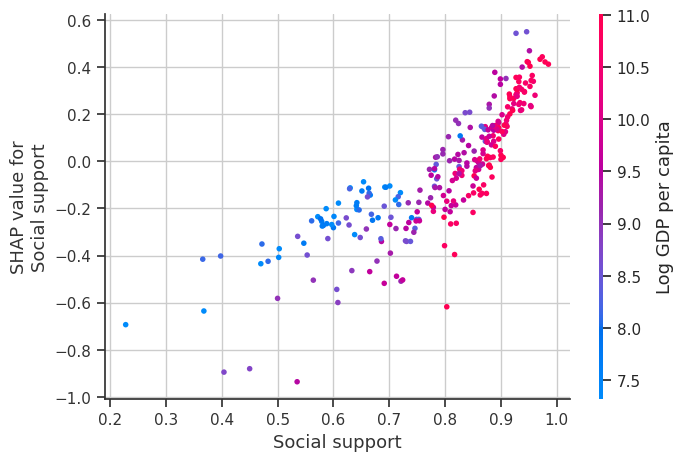


SHAP Dependence Plot for 'Healthy life expectancy at birth':


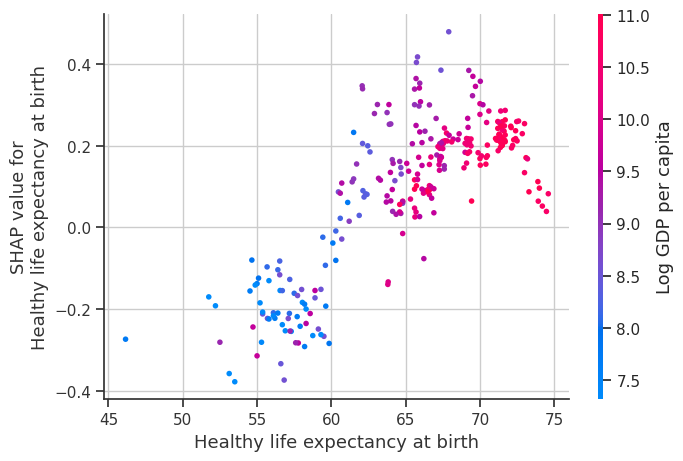


SHAP Dependence Plot for 'Freedom to make life choices':


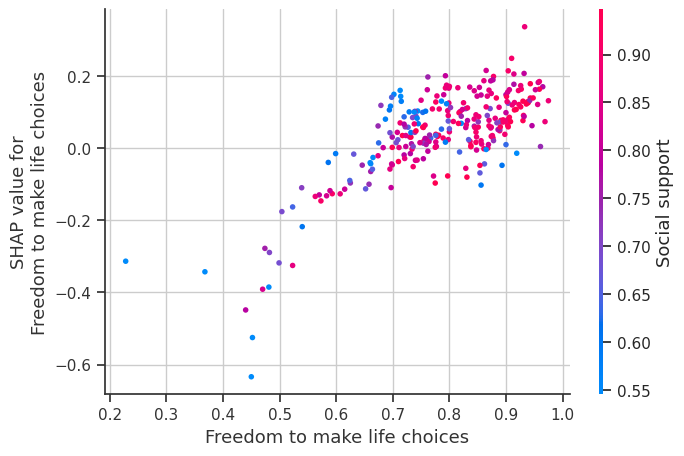


SHAP Dependence Plot for 'Generosity':


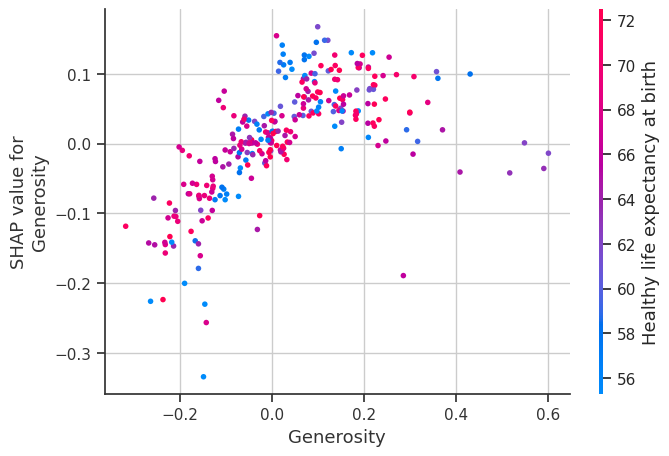


SHAP Dependence Plot for 'Perceptions of corruption':


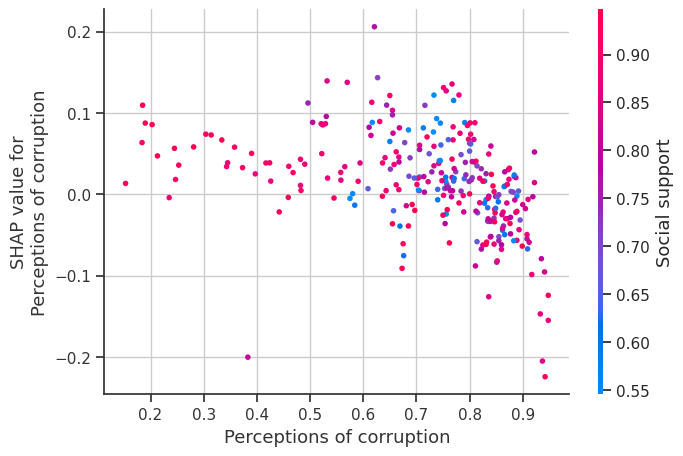

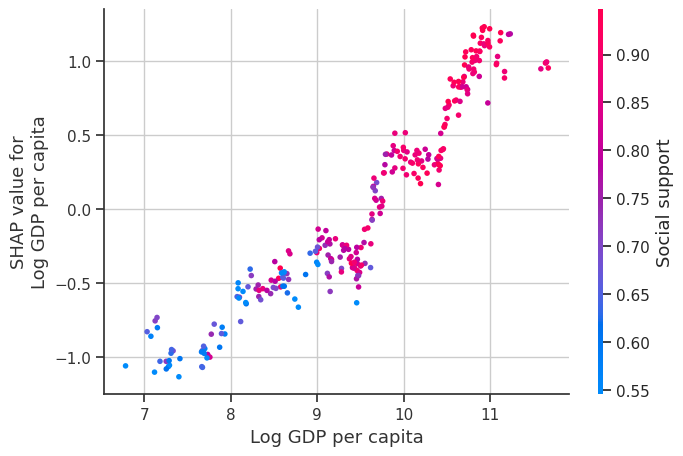

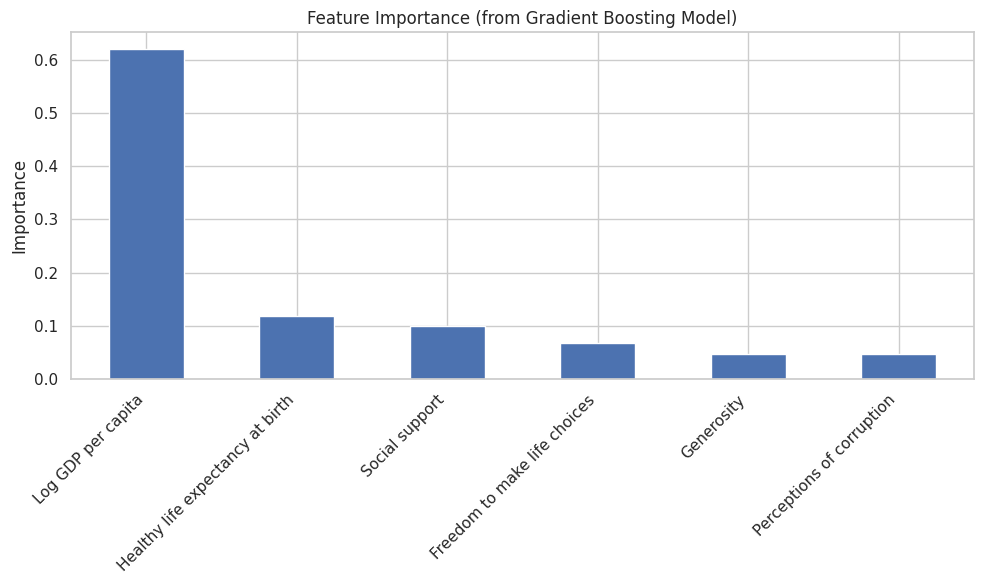

In [24]:
# Load the best model
best_model = joblib.load('gb_seed_1005904197.pkl')

y_pred_best = best_model.predict(X_val)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("Actual Life Ladder")
plt.ylabel("Predicted Life Ladder")
plt.title(f"Best Model (Gradient Boosting) - Actual vs Predicted on Validation Data")
plt.grid(True)
plt.show()

# SHAP
explainer_best = shap.TreeExplainer(best_model)
shap_values_best = explainer_best.shap_values(X_val)
print("SHAP Summary Plot:")
shap.summary_plot(shap_values_best, X_val)

for selected_feature in X_val.columns:
    print(f"\nSHAP Dependence Plot for '{selected_feature}':")
    shap.dependence_plot(selected_feature, shap_values_best, X_val, display_features=X_val)

# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=X_val.columns)
    sorted_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sorted_importances.plot(kind='bar')
    plt.title("Feature Importance (from Gradient Boosting Model)")
    plt.ylabel("Importance")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance is not directly available for this model type.")

In [25]:
sorted_importances

Log GDP per capita                  0.620559
Healthy life expectancy at birth    0.118739
Social support                      0.099342
Freedom to make life choices        0.067293
Generosity                          0.047618
Perceptions of corruption           0.046448
dtype: float64